# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/mandyoc-scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest

In [2]:
def calc_mean_region(data, xx, zz, xbegin, xend, zbegin, zend):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nx: int
        Number of points in X direction

    xx: numpy.ndarray
        2D grid with x cordinates

    zz: numpy.ndarray
        2D grid with z cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    mean: float
         Mean of selected region
    '''

    region  = (xx >= xbegin) & (xx <= xend) & (zz >= zbegin) & (zz <= zend)

    xregion = (xx >= xbegin) & (xx <= xend)
    zregion = (zz >= zbegin) & (zz <= zend)

    Nx_new = len(xregion[0][xregion[0] == True])
    Nz_new = len(zregion.T[0][zregion.T[0] == True])

    data_region = np.asarray(data)[region].reshape(Nz_new, Nx_new)
    mean = np.round(np.mean(data_region), 2)

    return mean

def calc_mean_evolutions(data, xx, zz, Lx, Lz, xcenter, Lcraton, mobile_belt=False):
    #Cratonic region
    if(mobile_belt):
        xcbegin = xcenter - 150
        xcend = xcenter + 150
        zcbegin = 300.0
        zcend = Lz/1.0e3
    else:
        xcbegin = xcenter - Lcraton/2.0e3 + 50
        xcend = xcenter + Lcraton/2.0e3 - 50
        zcbegin = 300.0
        zcend = Lz/1.0e3

    #Out of cratonic region - left side
    xlbegin = 200
    xlend = xcenter - Lcraton/2.0e3 - 200
    zlbegin = 300.0
    zlend = Lz/1.0e3

    #Out of cratonic region - right side
    xrbegin = xcenter + Lcraton/2.0e3 + 200
    xrend = Lx/1.0e3 - 200
    zrbegin = 300.0
    zrend = Lz/1.0e3

    t0 = data.time[0]
    start = int(t0)
    end = int(data.time.size - 1)
    step = 1

    temper_diff_dict = pymp.shared.dict()
    temper_craton_dict = pymp.shared.dict()
    temper_out_dict = pymp.shared.dict()

    with pymp.Parallel() as p:
        for index in p.range(start, end+step, step):
            datai = data.temperature[index].values.T

            meanc = calc_mean_region(datai, xx, zz, xcbegin, xcend, zcbegin, zcend)
            meanl = calc_mean_region(datai, xx, zz, xlbegin, xlend, zlbegin, zlend)
            meanr = calc_mean_region(datai, xx, zz, xrbegin, xrend, zrbegin, zrend)
            mean_out = np.mean([meanl, meanr])

            temper_craton_dict[index] = meanc
            temper_out_dict[index] = mean_out

            temper_diff = meanc - mean_out
            temper_diff_dict[index] = temper_diff

    ####################################################################################################################

    #Sorting the dictionaries 
    temper_diff_dict = dict(temper_diff_dict)
    temper_craton_dict = dict(temper_craton_dict)
    temper_out_dict = dict(temper_out_dict)

    temper_diff_evol = np.asarray([])
    temper_craton_evol = np.asarray([])
    temper_out_evol = np.asarray([])

    for element in sorted(temper_diff_dict):
        # print(element, temper_diff_dict[element])
        temper_diff_evol = np.append(temper_diff_evol, temper_diff_dict[element])
        temper_craton_evol = np.append(temper_craton_evol, temper_craton_dict[element])
        temper_out_evol = np.append(temper_out_evol, temper_out_dict[element])

    return temper_diff_evol, temper_craton_evol, temper_out_evol

In [3]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

# mb_comparison = True
mb_comparison = False

if(mb_comparison):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1",
                ]
else:
    scenarios = [
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_dataset):
        properties.append('pressure')
    if ('temperature' not in new_dataset):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")


<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 0 500 1000 1500 ... 198500 199000 199500 200000
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
    strain_rate  (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
    surface      (time, x) float64 ...
    viscosity    (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                    

[0, 4000.0] [-660.0, 40]


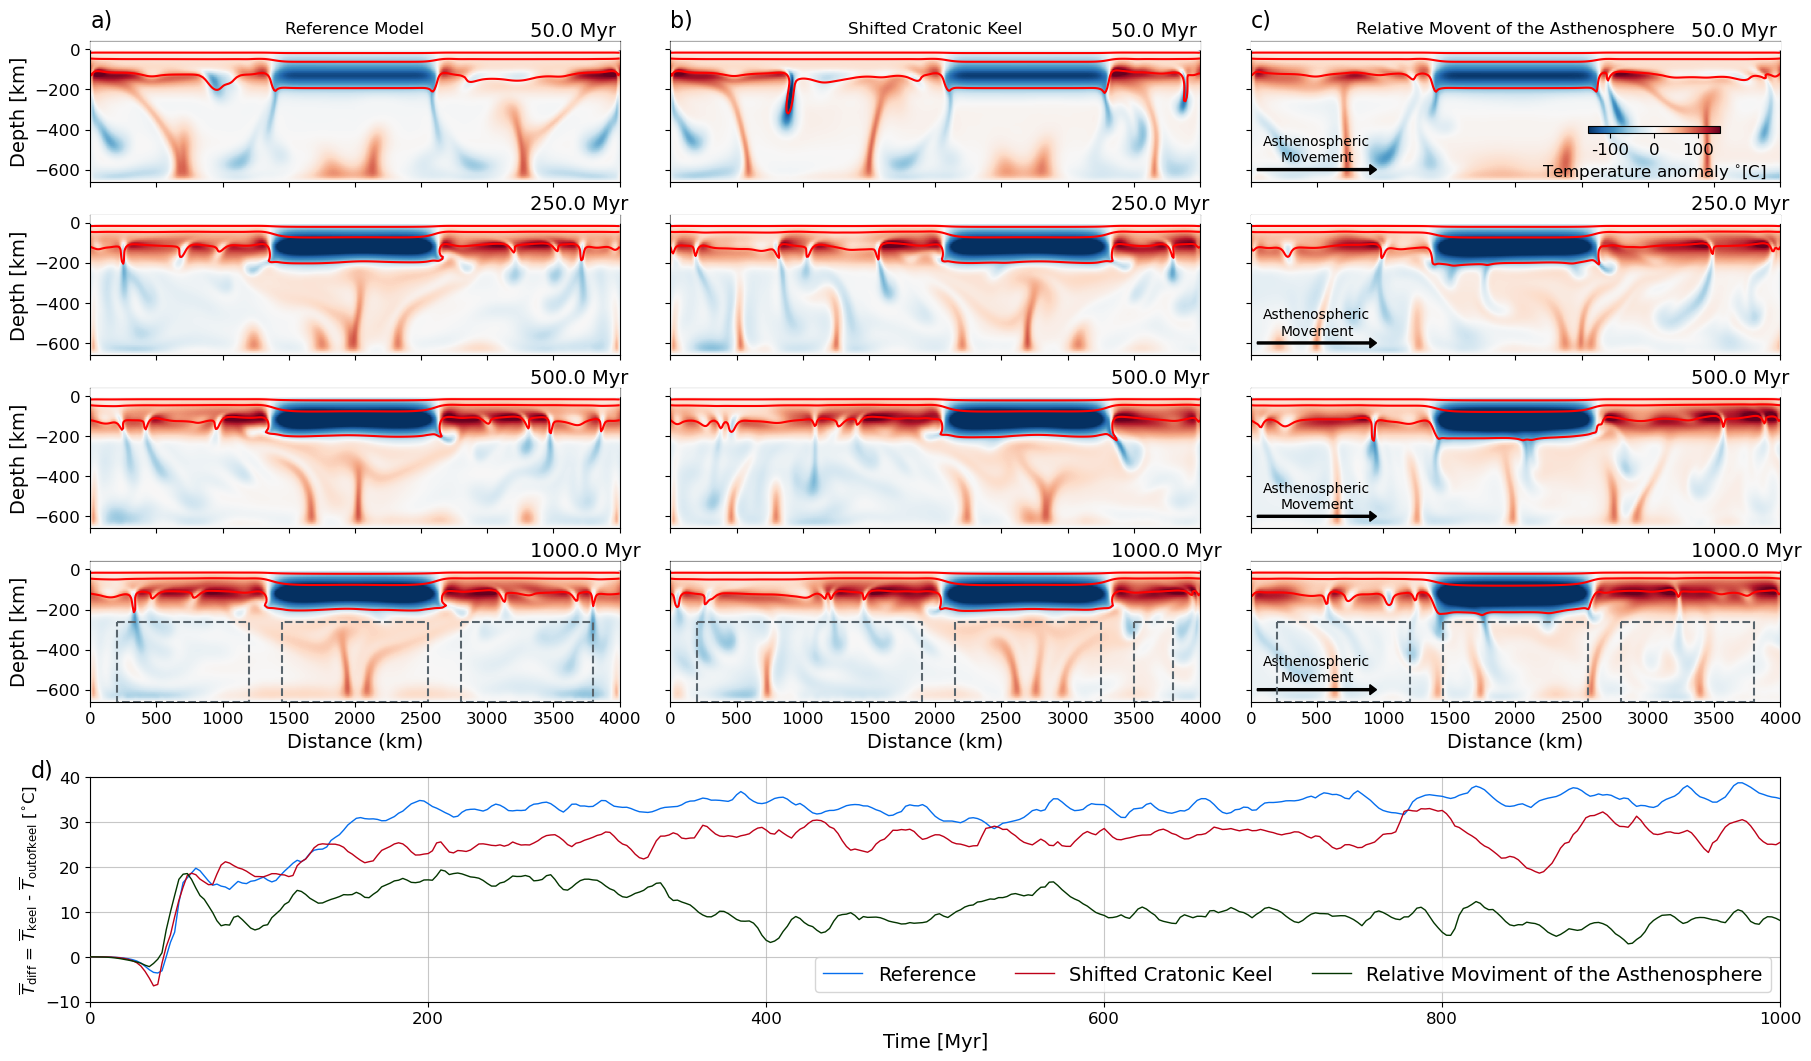

In [42]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
# prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

instants = [50, 250, 500, 1000] #Myr

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 3) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         ABC
         DEF
         GHI
         JKL
         MMM
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                               0.8
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
idxs = np.asarray(alphabet[0: 4*len(scenarios)]) #starting at A subplot
idxs_aux = idxs.reshape(len(scenarios)+1, 3)

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50]
        ylims = [-40, 10]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.5, 1.5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[idxs_aux[i, 0]],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_property(dataset1.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[idxs_aux[i, 1]],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_property(dataset2.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[idxs_aux[i, 2]],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )


##########################
#Set plot details
##########################
shift_craton = 0.0e3
xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3
Lcraton = 1200.0e3

#plot selection in asthenosphere in the last subplot
xc_points = np.asarray([xcenter - Lcraton/2.0e3 + 50,
                xcenter - Lcraton/2.0e3 + 50, 
                xcenter + Lcraton/2.0e3 - 50,
                xcenter + Lcraton/2.0e3 - 50,
                xcenter - Lcraton/2.0e3 + 50])

zc_points = np.asarray([300,
            Lz/1000,
            Lz/1000,
            300,
            300])

#Out of cratonic region - left side
xl_points = np.asarray([200,
            xcenter - Lcraton/2.0e3 - 200,
            xcenter - Lcraton/2.0e3 - 200,
            200,
            200])
zl_points = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])

xr_points = np.asarray([xcenter + Lcraton/2.0e3 + 200,
            Lx/1000-200,
            Lx/1000-200,
            xcenter + Lcraton/2.0e3 + 200,
            xcenter + Lcraton/2.0e3 + 200])
zr_points = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])

axs['J'].plot(xc_points, -zc_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['J'].plot(xl_points, -zl_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['J'].plot(xr_points, -zr_points+40, '--', color='xkcd:slate grey', zorder=51)

axs['L'].plot(xc_points, -zc_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['L'].plot(xl_points, -zl_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['L'].plot(xr_points, -zr_points+40, '--', color='xkcd:slate grey', zorder=51)

shift_craton = 700.0e3
xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3
xc_points = np.asarray([xcenter - Lcraton/2.0e3 + 50,
                xcenter - Lcraton/2.0e3 + 50, 
                xcenter + Lcraton/2.0e3 - 50,
                xcenter + Lcraton/2.0e3 - 50,
                xcenter - Lcraton/2.0e3 + 50])

zc_points = np.asarray([300,
            Lz/1000,
            Lz/1000,
            300,
            300])

#Out of cratonic region - left side
xl_points = np.asarray([200,
            xcenter - Lcraton/2.0e3 - 200,
            xcenter - Lcraton/2.0e3 - 200,
            200,
            200])
zl_points = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])

xr_points = np.asarray([xcenter + Lcraton/2.0e3 + 200,
            Lx/1000-200,
            Lx/1000-200,
            xcenter + Lcraton/2.0e3 + 200,
            xcenter + Lcraton/2.0e3 + 200])
zr_points = np.asarray([300,
            300,
            Lz/1000,
            Lz/1000,
            300])
axs['K'].plot(xc_points, -zc_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['K'].plot(xl_points, -zl_points+40, '--', color='xkcd:slate grey', zorder=51)
axs['K'].plot(xr_points, -zr_points+40, '--', color='xkcd:slate grey', zorder=51)

#Titles
axs['A'].set_title(r'Reference Model')
axs['A'].text(0.0, 1.1, f"a)", transform=axs['A'].transAxes, fontsize=16)

axs['B'].set_title(r'Shifted Cratonic Keel')
axs['B'].text(0.0, 1.1, f"b)", transform=axs['B'].transAxes, fontsize=16)

axs['C'].set_title(r'Relative Movent of the Asthenosphere')
axs['C'].text(0.0, 1.1, f"c)", transform=axs['C'].transAxes, fontsize=16)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for i in range(len(instants)):
    ax_name = idxs_aux[i, 2]
    axs[idxs_aux[i, 2]].text(500, -560, f"Asthenospheric\nMovement", ha='center')
    axs[idxs_aux[i, 2]].arrow(50, -600, 850, 0, width=10, head_width=50, head_length=50, fc='k', ec='k')

    axs[idxs_aux[i, 0]].set_ylabel('Depth [km]', fontsize=label_fsize)
    axs[idxs_aux[i, 1]].set_yticklabels([])
    axs[idxs_aux[i, 2]].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(i == len(instants) - 1):
        axs[idxs_aux[i, 0]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 1]].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[idxs_aux[i, 2]].set_xlabel('Distance (km)', fontsize=label_fsize)
        
    else:
        axs[idxs_aux[i, 0]].set_xticklabels([])
        axs[idxs_aux[i, 1]].set_xticklabels([])
        axs[idxs_aux[i, 2]].set_xticklabels([])

####################################################################################################################
#Plotting the mean evolution of the temperature difference in the last subplot
####################################################################################################################

datasets = [dataset0, dataset1, dataset2]
labels = ['Reference', 'Shifted Cratonic Keel', 'Relative Moviment of the Asthenosphere']
colors = ['xkcd:cerulean blue', 'xkcd:scarlet', 'xkcd:dark green']

for scenario, dataset, label, color in zip(scenarios, datasets, labels, colors):

    model_features = scenario.split('/')[-1].split('_')
    if(('mbdo' in model_features) or ('mbwo' in model_features)):
        mobile_belt = True
    else:
        mobile_belt = False

    if('sc' in model_features):
        shift_craton = 700.0e3
        xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3
    else:
        shift_craton = 0.0e3
        xcenter = (Lx/2)/1.0e3 + shift_craton/1.0e3

    if('lc' in model_features):
        Lcraton = 2000.0e3 #m
    else:
        Lcraton = 1200.0e3

    if('shallow30' in model_features):
        thinning = 135.0e3
    else:
        thinning = 100.0e3

    temper_diff_evol, temper_craton_evol, temper_out_evol = calc_mean_evolutions(dataset, xx, zz, Lx, Lz, xcenter, Lcraton, mobile_belt=mobile_belt)
    axs['M'].plot(dataset.time.values, temper_diff_evol, linestyle='-', color=color,linewidth=1.0, alpha=1.0, zorder=30, label=label)

# axs['M'].set_title(r"Evolution of Mean Temperature Difference")
# axs['M'].text(-0.035, 1.0, f"e)", transform=axs['M'].transAxes, fontsize=16)
axs['M'].text(-0.035, 1.0, f"d)", transform=axs['M'].transAxes, fontsize=16)
axs['M'].legend(loc='lower right', fontsize=label_fsize, ncol=3)
axs['M'].set_ylabel(r"$\overline{T}_{\mathrm{diff}}$ = $\overline{T}_{\mathrm{keel}}$ - $\overline{T}_{\mathrm{out of keel}}$ [$^{\circ}$C]", fontsize=label_fsize-2)
axs['M'].set_ylim([-10, 40])

axs['M'].set_xlim([0, 1000])
axs['M'].set_xlabel('Time [Myr]', fontsize=label_fsize)
axs['M'].grid('-k', alpha=0.7)

figname = f"CK_ref_vs_shift_vs_aw_temper_diff_{prop}"
fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)

In [16]:
line_labels

array(['a', 'b'], dtype='<U1')

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

# mb_comparison = True
mb_comparison = False

if(mb_comparison):
    scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb5",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb3",
                f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/shallow_mb/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_shallow30_mbwo_Cmb1",
                ]
else:
    scenarios = [
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc",
                 f"{model_path}/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf",
                ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False
melt_method = 'dry'
# melt_method = 'wet'

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_dataset):
        properties.append('pressure')
    if ('temperature' not in new_dataset):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max

In [3]:
properties, new_datasets

(['lithology', 'strain_rate', 'temperature_anomaly', 'surface', 'viscosity'],
 ['strain', 'density', 'strain_rate', 'temperature', 'surface', 'viscosity'])

[0, 4000.0] [-660.0, 40]


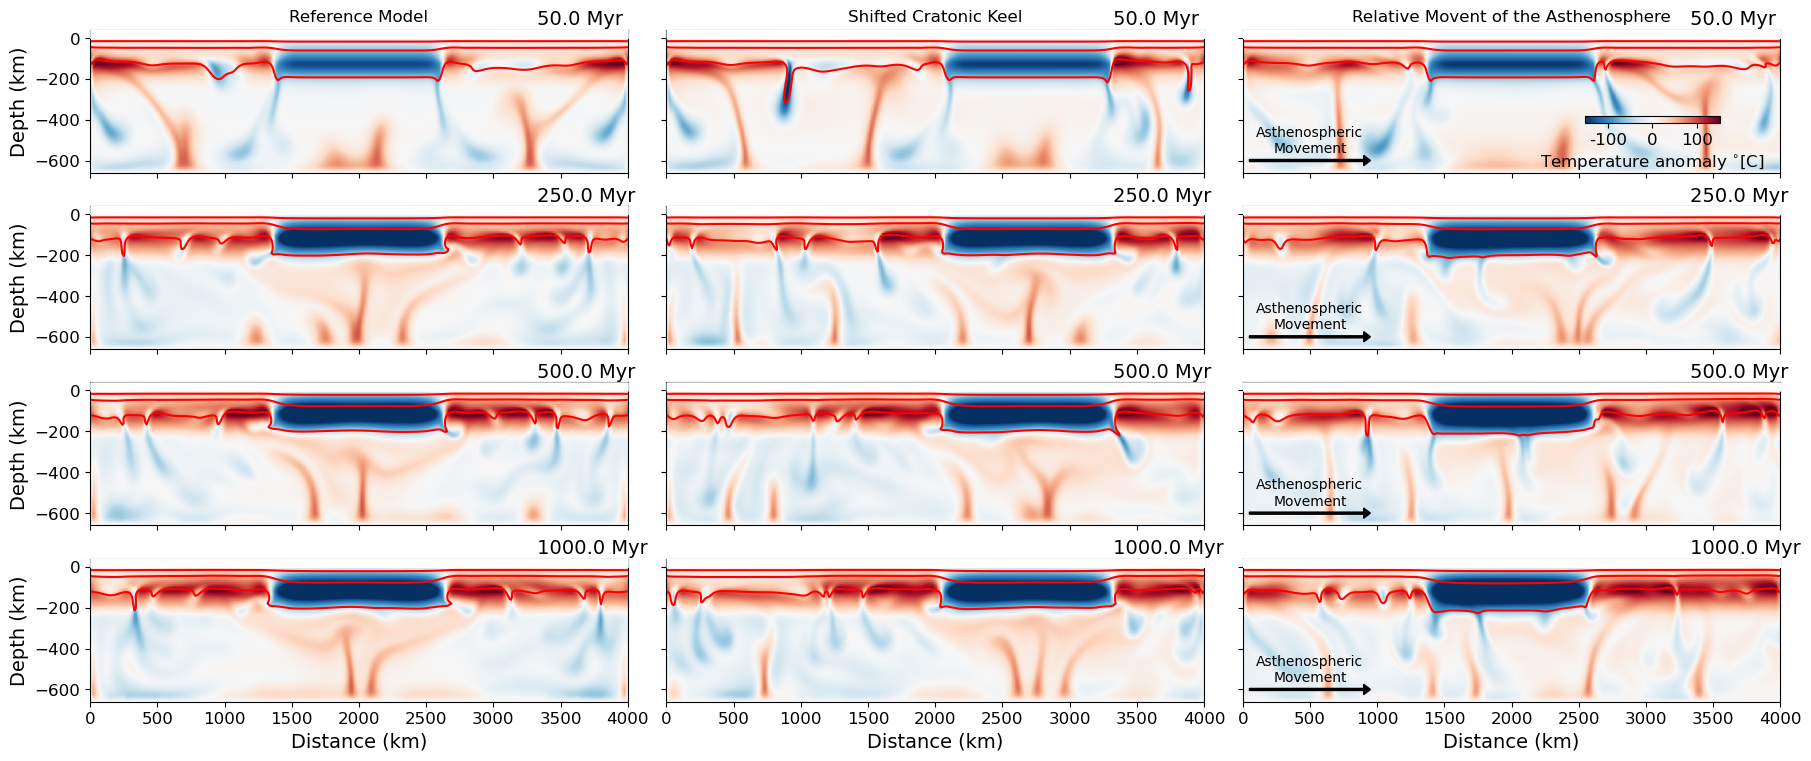

In [25]:

##############################################################################################################
#Creating path to the experiment

# fpath = machine_path + scenario
# print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
# prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [50, 250, 500, 1000] #Myr
else:
    instants = [0, 250, 500, 1000]

##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18, fig_height), sharex=False, sharey=True)
else:
    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18,4), sharex=False, sharey=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
# zoom_uc = True
zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50]
        ylims = [-40, 10]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.5, 1.5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False

    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[3*i],
             plot_isotherms = plot_isotherms,
             plot_particles = plot_particles,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )

    if(mb_comparison):
        xlims_aux = xlims
        ylims_aux = ylims
    else:
        if(zoom_uc):
            shift_craton = 700.0 #km
            xlims_aux = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 50 + shift_craton, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 50 + shift_craton]
            ylims_aux = [-40, 10]
        else:
            shift_craton = 700.0 #km
            xlims_aux = xlims
            ylims_aux = ylims

    plot_property(dataset1.isel(time=idx), prop, xlims_aux, ylims_aux, scenarios[1],
            fig,
            axs[3*i+1],
            plot_isotherms = plot_isotherms,
            plot_particles = plot_particles,
            particle_size = 0.2,
            particle_marker = ".",
            ncores = 20,
            #  step_plot = 4,
            isotherms = [500, 800, 1300],
            plot_colorbar=False,
            # plot_melt = plot_melt,
            # melt_method = melt_method,
            )

    plot_property(dataset2.isel(time=idx), prop, xlims, ylims, scenarios[2],
                fig,
                axs[3*i+2],
                plot_isotherms = plot_isotherms,
                plot_particles = plot_particles,
                particle_size = 0.2,
                particle_marker = ".",
                ncores = 20,
                # step_plot = 4,
                isotherms = [500, 800, 1300],
                plot_colorbar=plot_colorbar,
                # plot_melt = plot_melt,
                # melt_method = melt_method,
                )
    
# axs[0].set_title(r'CKR')
# axs[1].set_title(r'CKS')
        
# axs[1].set_title(r'CKMD0.01')
if(mb_comparison): 
    axs[0].set_title(r'Mobile Belt: 5 $\times$ Wet Olivine')
    axs[1].set_title(r'Mobile Belt: 3 $\times$ Wet Olivine')
    axs[2].set_title(r'Mobile Belt: 1 $\times$ Wet Olivine')
else:
    axs[0].set_title(r'Reference Model')
    axs[1].set_title(r'Shifted Cratonic Keel')
    axs[2].set_title(r'Relative Movent of the Asthenosphere')


label_fsize = 14
for i in range(len(instants)):
    # axs[2*i].set_title(f"{letters[i]} - {instants[i]} Myr")
    # axs[2*i+1].set_title(f"{letters[i]} - {instants[i]} Myr")
    axs[3*i].set_ylabel('Depth (km)', fontsize=label_fsize)

    if(mb_comparison==False):
        axs[3*i+2].text(500, -560, f"Asthenospheric\nMovement", ha='center')
        axs[3*i+2].arrow(50, -600, 850, 0, width=10, head_width=50, head_length=50, fc='k', ec='k')

    if(i == len(instants) - 1):
        axs[3*i].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+1].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+2].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[3*i].set_xticklabels([])
        axs[3*i+1].set_xticklabels([])
        axs[3*i+2].set_xticklabels([])

if(zoom_uc):
    if(mb_comparison):
        figname = f"CK_mbwo_comparison_{prop}_zoom_uc"
    else:
        figname = f"CK_ref_vs_shift_vs_aw_{prop}_zoom_uc"
else:
    if(mb_comparison):
        figname = f"CK_mbwo_comparison_{prop}"
    else:
        figname = f"CK_ref_vs_shift_vs_aw_{prop}"

# figname = f"POSTER_CK_ref_vs_shift_vs_aw_{prop}"
# figname = f"CK_mbwo_comparison_{prop}"


# fig.savefig(f"figures/{figname}.png", dpi=200)
# fig.savefig(f"figures/{figname}.pdf", dpi=200)